<!--
 * @Author: TMJ
 * @Date: 2023-12-31 16:40:56
 * @LastEditors: TMJ
 * @LastEditTime: 2024-01-10 18:38:24
 * @Description: 请填写简介
-->
# MolOP Tutorial

MolOP supports 4 common cheminformatic file formats now:
- Coords file
  - GJF
  - XYZ
  - SDF
- QM output file
  - G16 LOG
  - G16 IRC
  - G16 FCHK
  - xTB OUT

All of them support the basic functions that:
- Recognize the molecule and give **standardized SMILES**
- Extract the geometry
- Extract the charge and multiplicity (XYZ file should be user given)
- Provide **RDKit molecule object / OpenBabel molecule object** with 3D coordinates
- Support multi-frame molecule in one file
- All physical properties are combined with explicit units provided by [pint](https://pint.readthedocs.io/en/stable/index.html), witch can be easily transformed to other units

For G16 LOG file (and other QM output files future), it also supports:
- Extract the **energy** (and thermal Energies/Enthalpies/Free Energies/zero-point Energies with correction or not), with unit Hartree/Particle
- Extract the **partial charges** (Mulliken charges)
- Extract the **gradient**, with unit Hartree/Bhor
- Extract the **orbitals energies** (alpha, beta) and HOMO/LUMO, with unit Hartree/Particle
- Extract the **frequencies** with Reduced masses, force constants, IR intensities, normal coordinates and check if it is **imaginary**
- Extract the **Hessian** stored in a flatten lower triangular portion
- All frame in the optimalization will be processed by steps above, **not only the last frame**

## Get Start

In [1]:
from molop import AutoParser
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400, 400

`AutoParser` is the unique entrypoint of MolOP, which contains multiple FileParsers. FileParser contains multiple blocks, and BlockParser will process the single block.

Thus, if you want to access a certain molecule structure, you need use `files[0][0]` equal to the first frame in the first file.

### Batch process

MolOP offer batch process functions. You can pass a File wildcard string to read all available files in this directory, then you can access the file parsers like list.

The read process is automatically parallelized using all cores.

In [2]:
# give a File wildcard
files = AutoParser("../tests/test_files/mix_format/*.log")
files.to_summary_df()  # show basic infos

MolOP parsing with single thread:   0%|          | 0/3 [00:00<?, ?it/s]No version found in /home/tmj/proj/MolOP/tests/test_files/mix_format/RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-Anion_From-IP_C-O-190_TS_Opt.log
Failed to parse file /home/tmj/proj/MolOP/tests/test_files/mix_format/RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-Anion_From-IP_C-O-190_TS_Opt.log with G16LogFileParser. 1 validation error for G16LogFileParser
  Value error, No version found in /home/tmj/proj/MolOP/tests/test_files/mix_format/RE_BOX-Anion-Real_Cu-III-Phenol_Major-Amide-Anion_From-IP_C-O-190_TS_Opt.log [type=value_error, input_value={'file_path': '/home/tmj/...only_last_frame': False}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.7/v/value_error
MolOP parsing with single thread: 100%|██████████| 3/3 [00:00<00:00, 15.45it/s]
1 files failed to parse, 2 successfully parsed


,parser,file_path,file_name,file_format,version,frame_index,charge,multiplicity,SMILES,functional,basis,solvent_model,solvent,temperature,status,is_error,is_optimized,is_TS
0,G16LogFrameParser,/home/tmj/proj/MolOP/tests/test_files/mix_form...,TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16.log,.log,Gaussian 16: ES64L-G16RevB.01 20-Dec-2017\n ...,73,0,1,C=[N+](C)[N-]C.COC(=O)[C@@]1(OC)C#CC(Br)(Br)CCCC1,rb3lyp,def2svp,SMD-IEFPCM,Water,298.15 kelvin,"{'SCF Done': True, 'Maximum Force': True, 'RMS...",False,True,True
1,G16LogFrameParser,/home/tmj/proj/MolOP/tests/test_files/mix_form...,dsgdb9nsd_131941-4+.log,.log,Gaussian 16: ES64L-G16RevC.01 3-Jul-2019\n ...,21,1,1,CN1[C+]=CC([N+](=O)[O-])=C1,rb3lyp,"6-311+g(d,p)",,,298.15 kelvin,"{'SCF Done': True, 'termination': 'Normal'}",False,True,False


In [3]:
files[0]  # access file parser like list

G16LogFileParser(file_path='/home/tmj/proj/MolOP/tests/test_files/mix_format/TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16.log', charge=0, multiplicity=1, qm_software='Gaussian', qm_software_version='Gaussian 16:  ES64L-G16RevB.01 20-Dec-2017\n                22-Oct-2022', keywords=' %mem=30399MB  %nprocshared=8  Will use up to    8 processors via shared memory. \n\n # B3LYP def2svp Freq EmpiricalDispersion=GD3BJ Opt=(TS, CalcFC, NoEigenTest, MaxCycles=100, MaxStep=10, NoTrustUpdate, RecalcFC=30) IOp(2/9=2000) Geom=ModRedun NoSymm scrf=(smd,solvent=Water)\n', method='DFT', basis='def2svp', functional='rb3lyp', solvent='water', solvent_model='smd', solvent_epsilon=0.0, solvent_epsilon_infinite=0.0, temperature=298.15, electron_temperature=<Quantity(298.15, 'kelvin')>, file_format='.log')

The batch object can transform all files into coords files (.xyz, .sdf and .gjf)

In [4]:
# If file_path is not given, files will be generated in situ
files.to_XYZ_file(file_path="../tests/test_files/temp")
# If file_path is not given, files will be generated in situ
files.to_SDF_file(file_path="../tests/test_files/temp")
files.to_GJF_file(
    file_path="../tests/test_files/temp",
    prefix="""# some parameters""",
    suffix="""some basis""",
)  # fill the prefix and suffix, then generate new gjf parameters with old coords

xyz files saved to /home/tmj/proj/MolOP/tests/test_files/temp
sdf files saved to /home/tmj/proj/MolOP/tests/test_files/temp
gjf files saved to /home/tmj/proj/MolOP/tests/test_files/temp


In [5]:
# If file_path is not given, files will be generated in situ
files.to_chemdraw(file_path="../tests/test_files/temp")

chemdraw files saved to /home/tmj/proj/MolOP/tests/test_files/temp


New .gjf file example:

Use code below can create csv table with informations above

In [6]:
files.to_summary_csv(
    file_path="../tests/test_files/temp"
)  # if file_path not given, summary will be created in situ

summary csv saved to /home/tmj/proj/MolOP/tests/test_files/temp/summary.csv


Replace substituents in batches

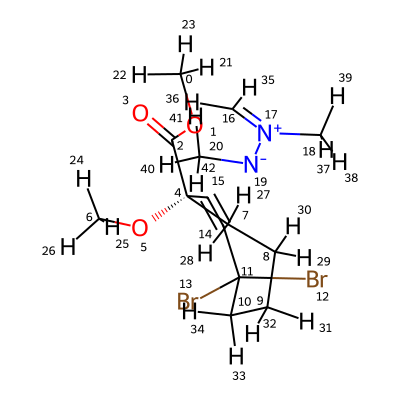

In [7]:
"""
Author: TMJ
Date: 2024-02-17 15:17:37
LastEditors: TMJ
LastEditTime: 2024-02-20 12:41:32
Description: 请填写简介
"""

files[0][0].rdmol

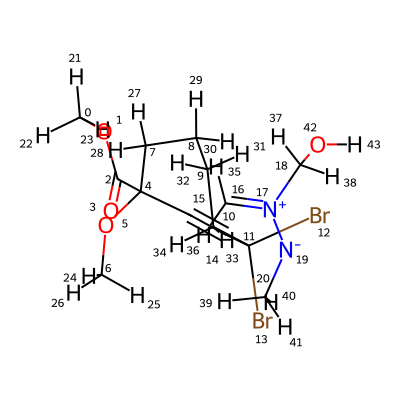

In [8]:
# If bond_idx given, will try to replace the legal substituent binding to bond_idx
files[0][0].replace_substituent("[H]", "[O][H]", bind_idx=39).rdmol

In [9]:
new_blocks = files.replace_substituent("[H]", "[C](C)(C)C", bind_idx=None)

100%|██████████| 2/2 [00:00<00:00, 14.21it/s]
1 files successfully replaced, 1 files failed to replace


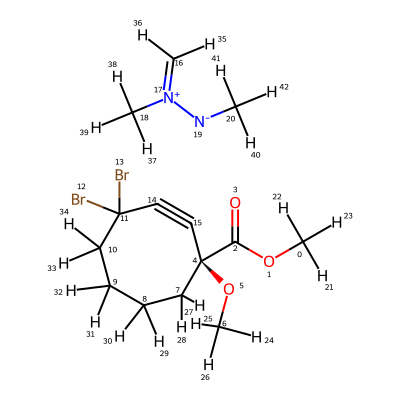

In [10]:
files[0][-1].rdmol_no_conformer

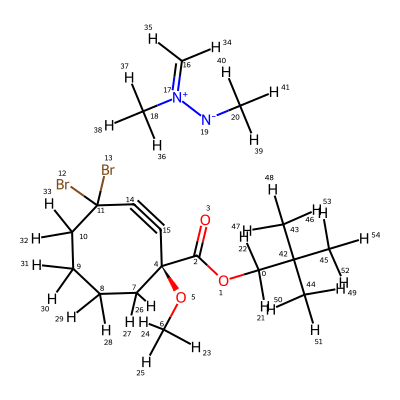

In [11]:
new_blocks[0][0].rdmol_no_conformer

Reset atom index in batches

MolOP parsing with single thread: 100%|██████████| 4/4 [00:00<00:00, 12.99it/s]
0 files failed to parse, 4 successfully parsed


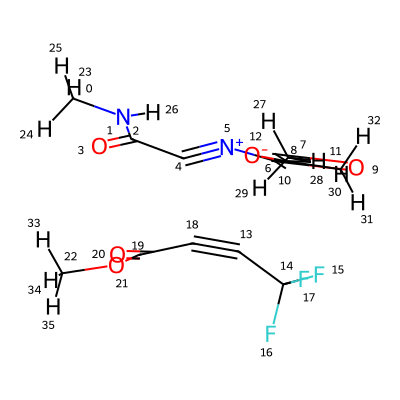

In [12]:
files = AutoParser("../tests/test_files/test_reset_index/*")
files[0][-1].rdmol

100%|██████████| 4/4 [00:00<00:00, 322.09it/s]
4 files successfully replaced, 0 files failed to reset_index


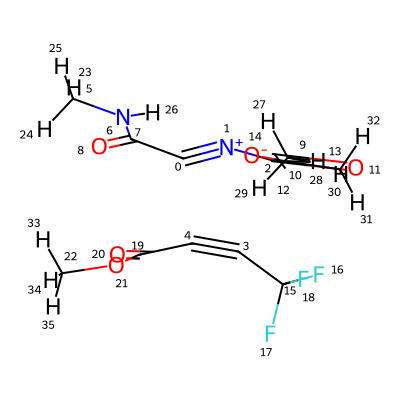

In [13]:
new_files = files.reset_atom_index("[*^1,*^2]~[*+1^1,*+1^2]~[*+0^1,*+0^2].[C]#[C]")

new_files[0][0].rdmol

In [14]:
new_files.to_summary_df()

,parser,file_path,file_name,file_format,frame_index,charge,multiplicity,SMILES
0,SDFFrameParser,/home/tmj/proj/MolOP/tests/test_files/test_res...,TS_4cGKps_ll_ad_4-18_6-13_optts_g16_reindex.sdf,.sdf,0,0,1,CNC(=O)C#[N+]C(C(C)=O)=C(C)[O-].COC(=O)C#CC(F)...
1,SDFFrameParser,/home/tmj/proj/MolOP/tests/test_files/test_res...,TS_4cGKps_ll_ad_4-18_6-13_sp_g16_reindex.sdf,.sdf,0,0,1,CNC(=O)C#[N+]C(C(C)=O)=C(C)[O-].COC(=O)C#CC(F)...
2,SDFFrameParser,/home/tmj/proj/MolOP/tests/test_files/test_res...,TS_Zy0fwX_ll_ad_14-19_15-16_optts_g16_reindex.sdf,.sdf,0,0,1,C=[N+](C)[N-]C.COC(=O)[C@@]1(OC)C#CC(Br)(Br)CCCC1
3,SDFFrameParser,/home/tmj/proj/MolOP/tests/test_files/test_res...,TS_ts_guess_FaFxyx_template_4-18_6-13_optts_co...,.sdf,0,0,1,CNC(=O)C#[N+]C(C(C)=O)=C(C)[O-].COC(=O)C#CC(F)...


### Single file process

#### XYZ file TS with Metal and Radical

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 1212.23it/s]
0 files failed to parse, 1 successfully parsed


frame num: 1; atom num: 64
SMILES: CC(C)(C1=NCCO1)C1=NCCO1.C[C](C)N(C)C.Cl[Cu]c1ccc2ccccc2c1


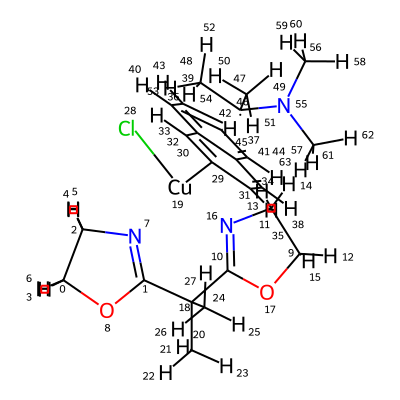

In [15]:
from molop import AutoParser

test_xyz_file = AutoParser("../tests/test_files/xyz/test.xyz", charge=0, multiplicity=3)
print(f"frame num: {len(test_xyz_file)}; atom num: {len(test_xyz_file[0][0])}")
print(f"SMILES: {test_xyz_file[0][0].to_standard_SMILES()}")
test_xyz_file[0][0].rdmol

#### G16 LOG with Single Point

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 276.45it/s]
0 files failed to parse, 1 successfully parsed


frame num: 1; atom num: 33
SMILES: CCC[C@H]1CO[C@H]2C[C@@](C)(O)C[C@@H]12
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB 

 # def2tzvp m06l



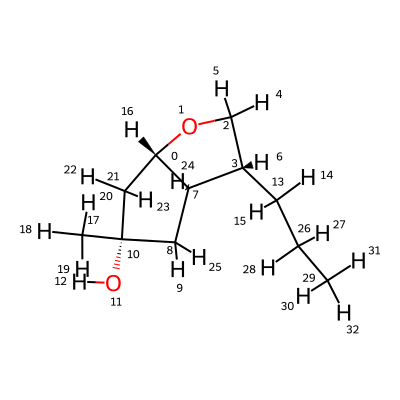

In [16]:
test_sp_file = AutoParser("../tests/test_files/g16log/3_Sp.log")
print(f"frame num: {len(test_sp_file[0])}; atom num: {len(test_sp_file[0][0])}")
print(f"SMILES: {test_sp_file[0][0].to_standard_SMILES()}")
print(f"parameter comment: \n{test_sp_file[0][0].keywords}")
test_sp_file[0][0].rdmol

In [17]:
test_sp_file[0][0].energies

Energies(electronic_energy=None, scf_energy=<Quantity(-581.780923, 'hartree / particle')>, mp2_energy=None, mp3_energy=None, mp4_energy=None, ccsd_energy=None, total_energy=<Quantity(-581.780923, 'hartree / particle')>)

In [18]:
test_sp_file[0][0].thermal_energies

ThermalEnergies(ZPVE=None, U_0=None, TCE=None, TCH=None, TCG=None, U_T=None, H_T=None, G_T=None, S=None, C_V=None)

In [19]:
print(
    f"partial charges num: {len(test_sp_file[0][0].charge_spin_populations.mulliken_charges)}"
)
print(f"first 5: {test_sp_file[0][0].charge_spin_populations.mulliken_charges[:5]}")

partial charges num: 33
first 5: [0.139353, -0.485914, 0.185647, 0.20812, 0.028079]


In [20]:
print(f"No freq No forces: {test_sp_file[0][0].forces}")

No freq No forces: [] hartree / bohr


In [21]:
print(f"No freq parameter No freq: {test_sp_file[0][0].vibrations}")

No freq parameter No freq: frequencies=<Quantity([], 'reciprocal_centimeter')> reduced_masses=<Quantity([], 'unified_atomic_mass_unit')> force_constants=<Quantity([], 'millidyne / angstrom')> IR_intensities=<Quantity([], 'kilomole / mole')> vibration_modes=[]


In [22]:
test_sp_file[0][0].molecular_orbitals[0]

MoleculeOrbital(alpha_energy=<Quantity(-18.96318, 'hartree / particle')>, beta_energy=<Quantity(-18.96318, 'hartree / particle')>, alpha_occupancy=True, beta_occupancy=True)

#### G16 LOG with Opt

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 26.15it/s]
0 files failed to parse, 1 successfully parsed


frame num: 13; atom num: 31
SMILES: C=C[C@H]1[C@@H]2[C@H](C[C@@]1(C)O)OC[C@@H]2C
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB 

 # opt=maxcycle=150 freq def2svp m06l



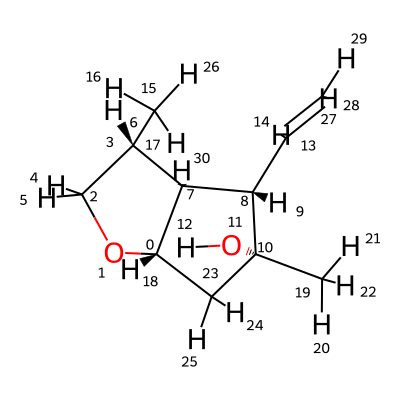

In [23]:
test_opt_file = AutoParser("../tests/test_files/g16log/11_Opt.log")
print(f"frame num: {len(test_opt_file[0])}; atom num: {len(test_opt_file[0][-1])}")
print(f"SMILES: {test_opt_file[0][-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_opt_file[-1].keywords}")
test_opt_file[0][-1].rdmol

In [24]:
test_opt_file[0][-1].energies

Energies(electronic_energy=None, scf_energy=<Quantity(-579.925317, 'hartree / particle')>, mp2_energy=None, mp3_energy=None, mp4_energy=None, ccsd_energy=None, total_energy=<Quantity(-579.925317, 'hartree / particle')>)

In [25]:
test_opt_file[0][-1].thermal_energies

ThermalEnergies(ZPVE=<Quantity(172.932198, 'kilocalorie / mole')>, U_0=<Quantity(-363735.698, 'kilocalorie / mole')>, TCE=<Quantity(180.66186, 'kilocalorie / mole')>, TCH=<Quantity(181.254229, 'kilocalorie / mole')>, TCG=<Quantity(149.602024, 'kilocalorie / mole')>, U_T=<Quantity(-363727.969, 'kilocalorie / mole')>, H_T=<Quantity(-363727.376, 'kilocalorie / mole')>, G_T=<Quantity(-363759.029, 'kilocalorie / mole')>, S=<Quantity(106.164, 'calorie / kelvin / mole')>, C_V=<Quantity(50.588, 'calorie / kelvin / mole')>)

In [26]:
print(
    f"partial charges num: {len(test_sp_file[0][0].charge_spin_populations.mulliken_charges)}"
)
print(f"first 5: {test_sp_file[0][0].charge_spin_populations.mulliken_charges[:5]}")

partial charges num: 33
first 5: [0.139353, -0.485914, 0.185647, 0.20812, 0.028079]


In [27]:
test_opt_file[0][-1].forces

Magnitude,[[-2.1129999367985874e-06 4.62300022263662e-06 -3.460000016275444e-06] [-4.570999863062752e-06 6.813999789301306e-06 2.586999926279532e-06] [5.39800021215342e-06 2.7940000109083485e-06 1.3330000001587905e-06] [6.230000053619733e-07 2.240999947389355e-06 -1.9829999473586213e-06] [-2.2429999262385536e-06 6.538999969052384e-06 1.908000058392645e-06] [-3.344000106153544e-06 4.2520000533841085e-06 -1.6610000557193416e-06] [3.6129999898548704e-06 1.1810000160039635e-06 1.9910000901290914e-06] [-7.255000127770472e-06 8.869999987837218e-07 5.330000021785963e-06] [4.4270000216783956e-06 -3.434000063862186e-06 -6.333999863272766e-06] [-6.660000053670956e-07 -3.251999942222028e-06 1.2870000318798702e-06] [4.2189999476249795e-06 5.030000238548382e-07 1.1670000503727351e-06] [-1.1199999789823778e-06 1.4949999922464485e-06 -5.005999810236972e-06] [-6.299999881775875e-07 3.4999999343199306e-08 -3.529999901275005e-07] [1.1099999710495467e-06 -4.988000000594184e-06 4.475999958231114e-06] [2.9210000320745166e-06 1.4200000464370532e-07 2.6449999950273195e-06] [2.9410000479401788e-06 -1.343999997516221e-06 6.410999958461616e-06] [5.417000011220807e-06 6.951000159460818e-06 1.518999965810508e-06] [-7.570000093437557e-07 6.3460001911153086e-06 1.5929999790387228e-06] [-2.508000079615158e-06 -7.39999990173601e-08 -2.1260000266920542e-06] [-1.0163000297325198e-05 -2.2459998945123516e-06 -2.0299999903272692e-07] [-3.4639999739738414e-06 -2.3919999421195826e-06 -4.345999968791148e-06] [4.90000005015645e-08 -4.644999989977805e-06 -1.2210000477352878e-06] [-1.9039999870074098e-06 -5.758000042987987e-06 -3.6660001114796614e-06] [-4.286000148567837e-06 1.9899999870176543e-07 -3.2890000056795543e-06] [-2.6479999633011175e-06 -4.334000095695956e-06 -5.881000106455758e-06] [-4.9659997785056476e-06 -6.800000278417428e-07 -1.2609999657797744e-06] [6.9389998316182755e-06 3.2299999475071672e-06 1.8529999579186551e-06] [5.216999852564186e-06 -1.1189999895577785e-06 -5.780000265076524e-07] [3.160999995088787e-06 -6.145000043034088e-06 2.7720000161934877e-06] [3.6579999687091913e-06 -5.867999789188616e-06 5.56699978915276e-06] [2.9469999844877748e-06 -1.954000026671565e-06 -1.0730000212788582e-06]]
Units,hartree/bohr


In [28]:
print(f"first freq: {test_opt_file[0][-1].vibrations[0]}")

first freq: frequency=<Quantity(76.85, 'reciprocal_centimeter')> reduced_mass=<Quantity(3.0435, 'unified_atomic_mass_unit')> force_constant=<Quantity(0.0106, 'millidyne / angstrom')> IR_intensity=<Quantity(0.26, 'kilomole / mole')> vibration_mode=<Quantity([[-0.01  0.01 -0.01]
 [ 0.02  0.04 -0.04]
 [-0.03  0.07 -0.06]
 [-0.09  0.02  0.01]
 [ 0.01  0.08 -0.09]
 [-0.08  0.1  -0.1 ]
 [-0.15  0.07  0.03]
 [-0.06 -0.01 -0.  ]
 [-0.05 -0.05  0.02]
 [-0.05 -0.08  0.03]
 [ 0.   -0.05  0.03]
 [ 0.01 -0.03  0.02]
 [ 0.01  0.    0.01]
 [-0.03 -0.02 -0.01]
 [-0.23 -0.14  0.02]
 [-0.09 -0.05  0.05]
 [-0.1  -0.08  0.08]
 [-0.1  -0.09  0.01]
 [-0.03  0.02 -0.02]
 [ 0.02 -0.09  0.05]
 [ 0.06 -0.08  0.07]
 [ 0.   -0.1   0.04]
 [ 0.02 -0.13  0.06]
 [ 0.02 -0.02  0.02]
 [ 0.01 -0.05  0.04]
 [ 0.06 -0.01  0.03]
 [-0.1  -0.04  0.1 ]
 [ 0.28  0.19 -0.09]
 [ 0.51  0.32 -0.12]
 [ 0.32  0.23 -0.12]
 [-0.08 -0.    0.  ]], 'angstrom')> is_imaginary=False


In [29]:
test_opt_file[0][-1].molecular_orbitals[0]

MoleculeOrbital(alpha_energy=<Quantity(-18.98325, 'hartree / particle')>, beta_energy=<Quantity(-18.98325, 'hartree / particle')>, alpha_occupancy=True, beta_occupancy=True)

#### G16 LOG with TS

MolOP parsing with single thread: 100%|██████████| 1/1 [00:00<00:00, 16.90it/s]
0 files failed to parse, 1 successfully parsed


frame num: 13; atom num: 47
SMILES: Br[Ni](Br)(SCc1ccccc1)c1ccccc1.c1c[nH]cn1.c1c[nH]cn1
parameter comment: 
 %nprocshared=32  Will use up to   32 processors via shared memory.  %mem=100GB 

 # opt=(calcfc,ts,maxcycle=150,noeigen) freq ub3lyp/genecp empiricaldispersion=gd3bj



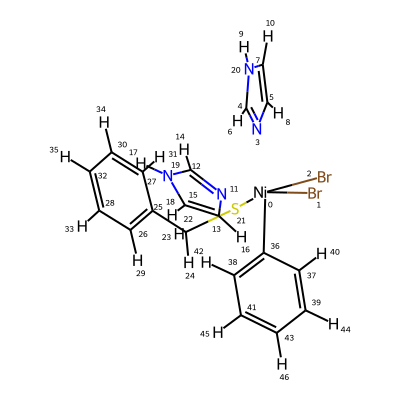

In [30]:
test_ts_file = AutoParser("../tests/test_files/g16log/S_Ph_Ni_TS.log")
print(f"frame num: {len(test_ts_file[0])}; atom num: {len(test_ts_file[0][-1])}")
print(f"SMILES: {test_ts_file[0][-1].to_standard_SMILES()}")
print(f"parameter comment: \n{test_ts_file[0][-1].keywords}")
test_ts_file[0][-1].rdmol

In [31]:
test_ts_file[0][-1].energies

Energies(electronic_energy=None, scf_energy=<Quantity(-1549.05355, 'hartree / particle')>, mp2_energy=None, mp3_energy=None, mp4_energy=None, ccsd_energy=None, total_energy=<Quantity(-1549.05355, 'hartree / particle')>)

In [32]:
test_ts_file[0][-1].thermal_energies

ThermalEnergies(ZPVE=<Quantity(226.882953, 'kilocalorie / mole')>, U_0=<Quantity(-971818.896, 'kilocalorie / mole')>, TCE=<Quantity(243.900382, 'kilocalorie / mole')>, TCH=<Quantity(244.492751, 'kilocalorie / mole')>, TCG=<Quantity(188.957535, 'kilocalorie / mole')>, U_T=<Quantity(-971801.878, 'kilocalorie / mole')>, H_T=<Quantity(-971801.286, 'kilocalorie / mole')>, G_T=<Quantity(-971856.821, 'kilocalorie / mole')>, S=<Quantity(186.267, 'calorie / kelvin / mole')>, C_V=<Quantity(99.359, 'calorie / kelvin / mole')>)

In [33]:
print(
    f"partial charges num: {len(test_sp_file[0][0].charge_spin_populations.mulliken_charges)}"
)
print(f"first 5: {test_sp_file[0][0].charge_spin_populations.mulliken_charges[:5]}")

partial charges num: 33
first 5: [0.139353, -0.485914, 0.185647, 0.20812, 0.028079]


In [34]:
test_ts_file[0][-1].forces

Magnitude,[[-2.529999960643181e-07 -3.12499992105586e-06 -6.649000170000363e-06] [5.859999987478659e-07 -1.0710000424296595e-06 -5.850000093232666e-07] [-3.92000004012516e-07 -6.930000040483719e-07 -7.130000199140341e-07] [-4.48199989477871e-06 -3.940000112834241e-07 2.0330001007096143e-06] [1.1880000556629966e-06 -5.769999802396342e-07 -6.980000080147875e-07] [3.0860001061228104e-06 -6.999999868639861e-08 -1.8409999711366254e-06] [-7.03000011981203e-07 -3.179999907843012e-07 -3.460000073118863e-07] [1.3589999525720486e-06 -8.500000348021786e-08 -1.1070000027757487e-06] [2.5099998879341e-07 -5.590000000665896e-07 -4.119999914564687e-07] [5.790000159322517e-07 -3.000000106112566e-07 -7.300000106624793e-07] [8.439999987785995e-07 -2.3799999837592622e-07 -8.430000093540002e-07] [1.8980000504598138e-06 2.401000074314652e-06 1.0170000450671068e-06] [-1.2330000345173175e-06 -2.781999910439481e-06 -2.4000000848900527e-06] [-1.8000000068241206e-07 8.199999967928306e-08 -7.759999789413996e-07] [5.559999749493727e-07 7.159999881878321e-07 -9.120000186157995e-07] [4.909999802293896e-07 -2.090000066345965e-07 4.5600000930789975e-07] [7.329999789362773e-07 1.1299999869152089e-07 -2.350000016804188e-07] [1.3800000431274384e-07 -3.9799999740353087e-07 5.100000066704524e-08] [6.08999982887326e-07 6.619999908252794e-07 3.119999973932863e-07] [-1.1539999604792683e-06 -1.349999934063817e-07 -7.000000135093387e-09] [1.053000005413196e-06 -1.6200000629851274e-07 -8.229999934883381e-07] [-6.48000025194051e-07 4.075000106240623e-06 -7.140000093386334e-07] [9.95000050352246e-07 -1.978999989660224e-06 1.2409999499141122e-06] [3.6000000136482413e-07 2.2300000068753434e-07 3.4799998616108496e-07] [-5.059999921286362e-07 -8.640000146442617e-07 4.2400000666020787e-07] [8.580000212532468e-07 2.10899997910019e-06 2.333000111320871e-06] [8.779999802754901e-07 9.960000397768454e-07 1.6550000054849079e-06] [4.199999921183917e-07 -1.9899999870176543e-07 1.120000021614942e-07] [7.819999723324145e-07 1.4879999525874155e-06 1.468000050408591e-06] [-5.809999947814504e-07 3.789999993841775e-07 3.8600001062150113e-07] [-1.8199999374246545e-07 2.529999960643181e-07 6.399999961104186e-07] [4.800000041882413e-08 3.250000020216248e-07 1.6200000629851274e-07] [6.729999881827098e-07 7.84000008025032e-07 7.740000000922009e-07] [-7.000000135093387e-09 7.689999961257854e-07 8.380000053875847e-07] [1.5300000200113573e-07 4.89000001380191e-07 2.419999987068877e-07] [4.2600001393111597e-07 7.439999762937077e-07 6.559999974342645e-07] [-3.107000111413072e-06 6.412999937310815e-06 4.468000042834319e-06] [2.2149999949760968e-06 -3.384999899935792e-06 -1.2330000345173175e-06] [-2.6780001007864485e-06 -2.8720000955217984e-06 2.0850000055361306e-06] [-1.0060000477096764e-06 4.139999987273768e-07 -4.1900000269379234e-07] [-5.350000265025301e-07 -5.549999855247734e-07 -5.300000225361146e-07] [-5.940000278314983e-07 1.1400000232697494e-07 -8.699999654027124e-08] [3.92000004012516e-07 -8.850000199345232e-07 -3.330000026835478e-07] [-1.4129999499346013e-06 -4.030000013699464e-07 2.639999934217485e-07] [-7.670000172765867e-07 -8.480000133204157e-07 -1.6699999605407356e-07] [-3.9099998616620724e-07 -1.610000026630587e-07 3.0199998946045525e-07] [-7.610000238855719e-07 -2.810000125919032e-07 2.9299999937393295e-07]]
Units,hartree/bohr


In [35]:
print(f"imaginary frequencies:")
test_ts_file[0][-1].vibrations.imaginary_vibrations

imaginary frequencies:


Vibrations(frequencies=<Quantity([-185.8656], 'reciprocal_centimeter')>, reduced_masses=<Quantity([8.7628], 'unified_atomic_mass_unit')>, force_constants=<Quantity([0.1784], 'millidyne / angstrom')>, IR_intensities=<Quantity([37.9609], 'kilomole / mole')>, vibration_modes=[<Quantity([[ 0.03  0.07 -0.07]
 [ 0.01 -0.01 -0.01]
 [-0.    0.01 -0.  ]
 [-0.05  0.07 -0.01]
 [-0.02  0.06  0.  ]
 [-0.03  0.06 -0.  ]
 [-0.01  0.07  0.01]
 [-0.    0.07  0.01]
 [-0.04  0.06 -0.  ]
 [ 0.03  0.07  0.02]
 [ 0.01  0.07  0.02]
 [ 0.02  0.01 -0.02]
 [ 0.02  0.01 -0.03]
 [-0.   -0.02  0.01]
 [ 0.04  0.04 -0.05]
 [-0.   -0.03  0.01]
 [-0.   -0.03  0.02]
 [ 0.01 -0.   -0.02]
 [-0.02 -0.05  0.02]
 [ 0.01 -0.01 -0.01]
 [ 0.    0.07  0.01]
 [ 0.11 -0.24 -0.11]
 [-0.03 -0.04  0.05]
 [-0.02  0.13  0.06]
 [-0.14 -0.1   0.17]
 [ 0.01 -0.01  0.  ]
 [ 0.   -0.    0.01]
 [ 0.02 -0.   -0.  ]
 [ 0.01  0.    0.  ]
 [-0.01 -0.01  0.01]
 [ 0.02  0.   -0.  ]
 [ 0.01 -0.    0.01]
 [ 0.02  0.    0.  ]
 [ 0.    0.    0.01]
 [

In [36]:
test_ts_file[0][-1].molecular_orbitals[0]

MoleculeOrbital(alpha_energy=<Quantity(-88.85698, 'hartree / particle')>, beta_energy=<Quantity(-88.85698, 'hartree / particle')>, alpha_occupancy=True, beta_occupancy=True)